In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.utils import plot_model
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import xgboost as xgb 
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import os
import scipy.io as sio
import math

### Evaluating ECG quality from Varying Input Sizes

In [2]:
sr = 100
quick_load = True
view_ind = 13

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


if(quick_load):
    X = np.load('../../data/PTBXL/X_raw.npy')
    Y = pd.read_csv('../../data/PTBXL/Y_raw.csv')
else:
    X,Y = load_data()

In [4]:
def subset_age(X, Y, age_lower, age_upper, input_amnt):
    X2 = X[(Y.age < age_upper) & (Y.age >= age_lower)]
    Y2 = Y[(Y.age < age_upper) & (Y.age >= age_lower)]
    X_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    Y_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    # Generate random indices based on the input_amnt ratio
    indices = np.random.choice(X_sub.shape[0], math.floor(input_amnt), replace=False)
    X_sub = X_sub[indices, :, :]
    Y_sub = Y_sub[indices]

    return X_sub, Y_sub

### Loading Fake ECGS

In [5]:
gen_10_percent = np.load("../../data/fake_ecgs/1000_0.1_[50-75]_generated_ecg_signals.npy")
gen_30_percent = np.load("../../data/fake_ecgs/1000_0.3_[50-75]_generated_ecg_signals.npy")
gen_75_percent = np.load("../../data/fake_ecgs/1000_0.75_[50-75]_generated_ecg_signals.npy")
gen_100_percent = np.load("../../data/fake_ecgs/10000_[50-75]_generated_ecg_signals.npy")[0:1000]
actual_X, actual_Y = subset_age(X, Y, 50, 75, 1000)

X_list = [gen_10_percent, gen_30_percent, gen_75_percent, gen_100_percent, actual_X]
X_list_names = ["10%", "30%", "75%", "100%", "actual_X"]



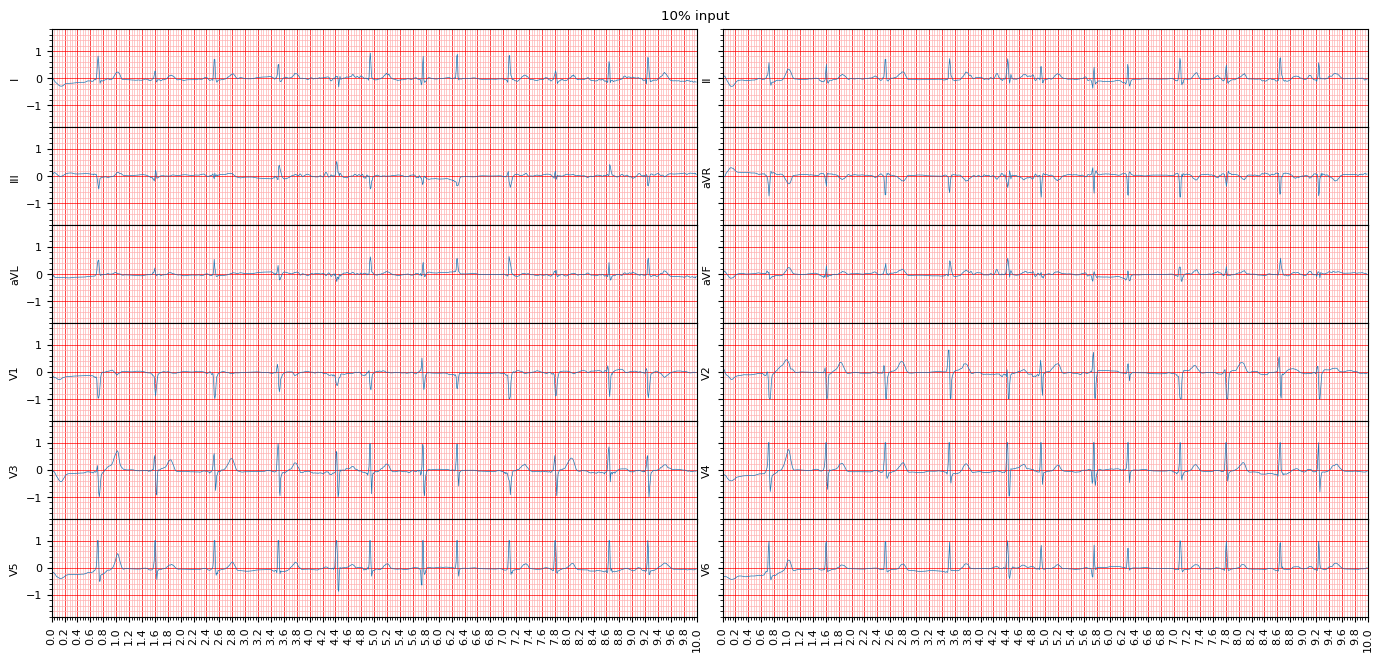

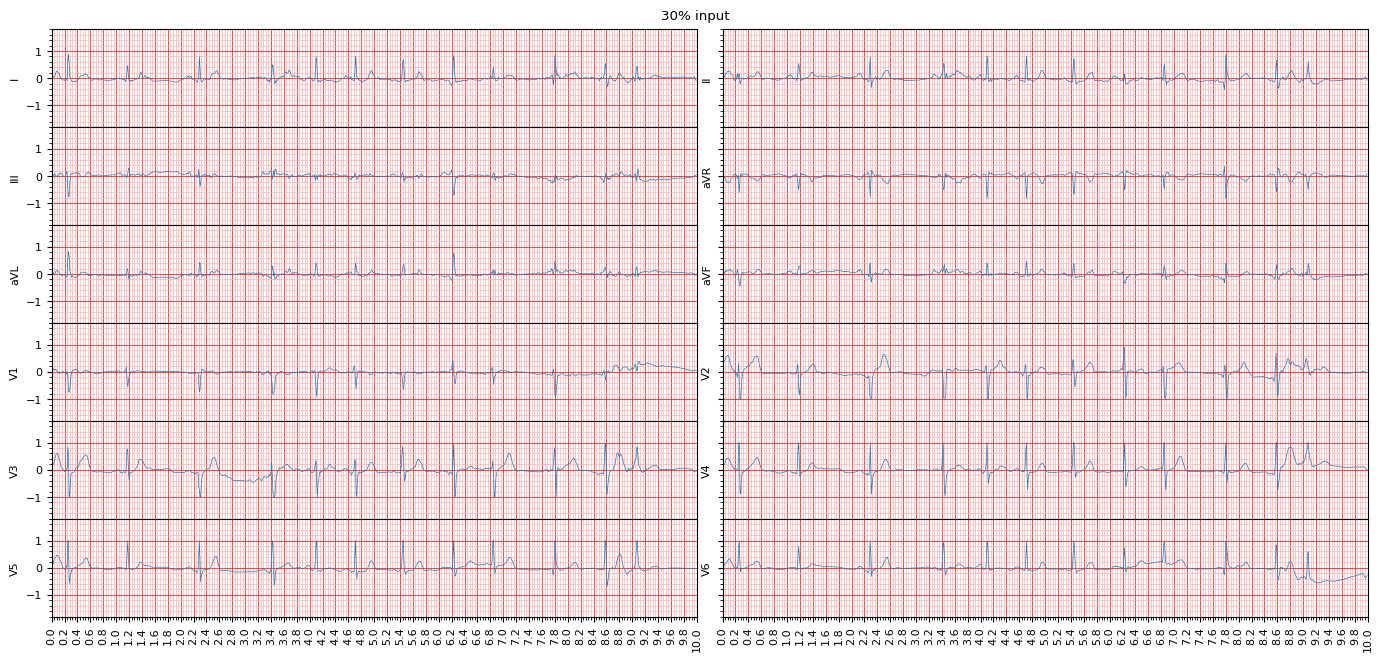

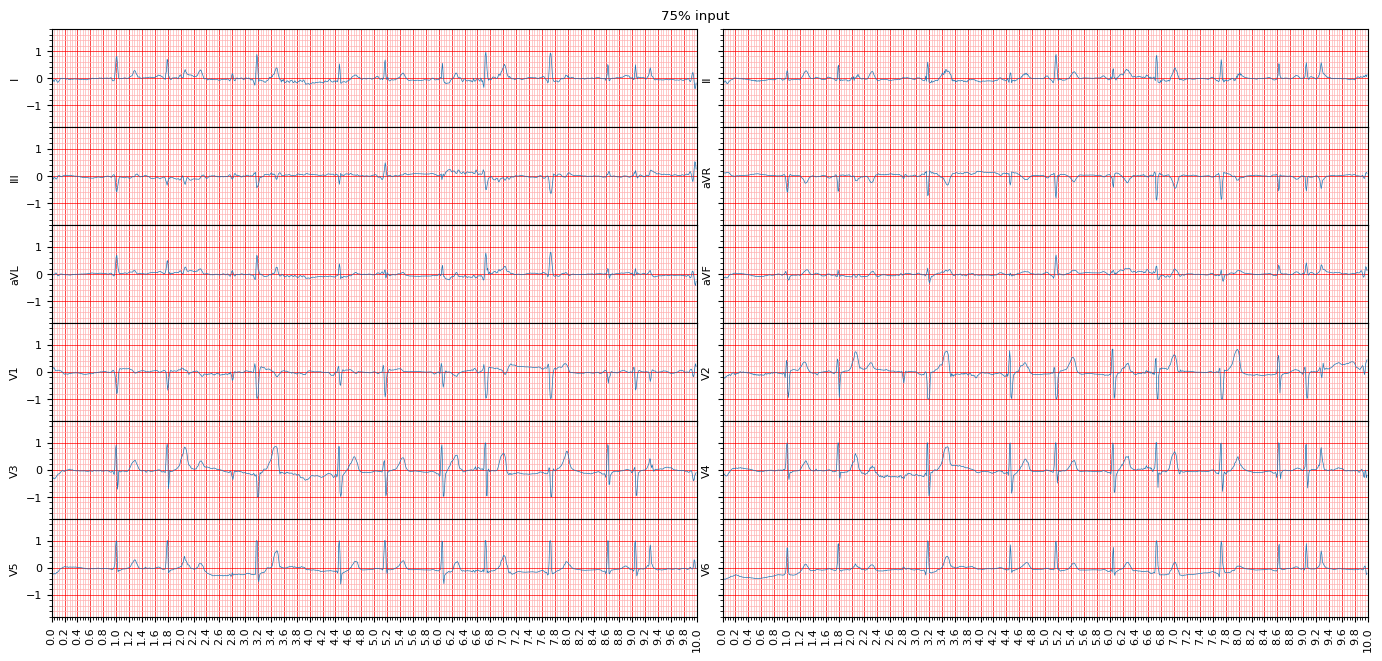

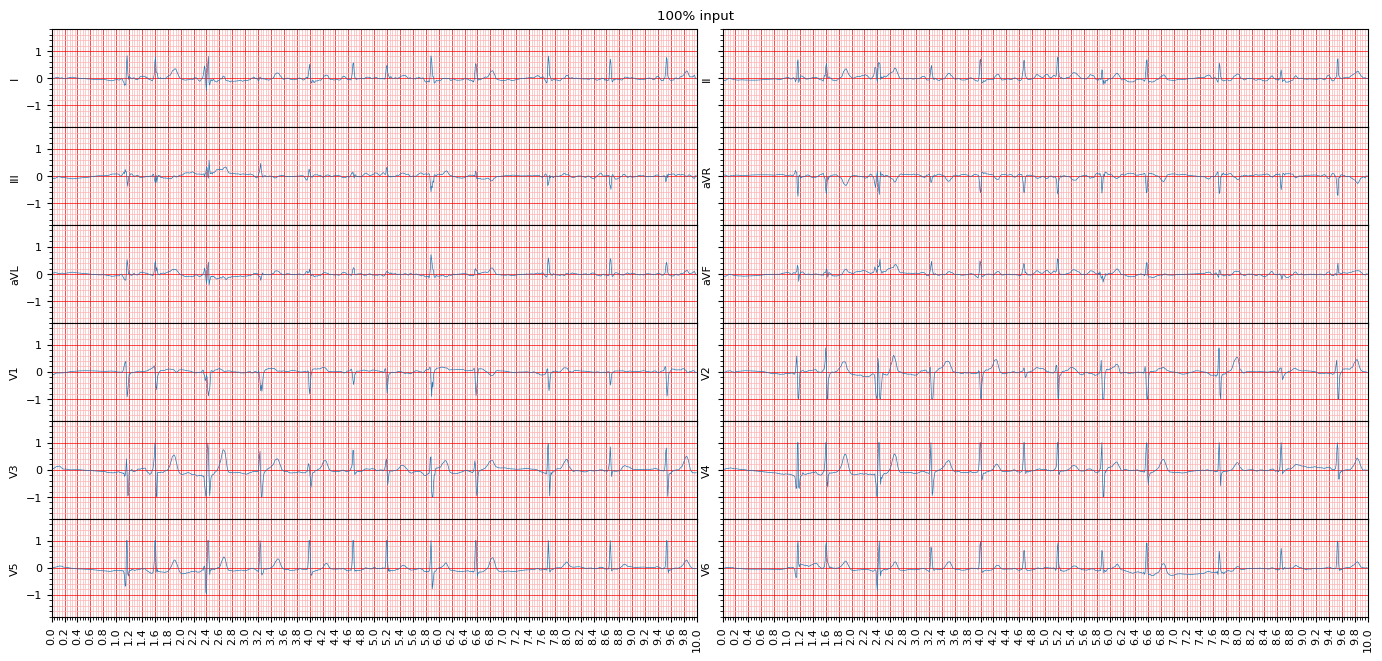

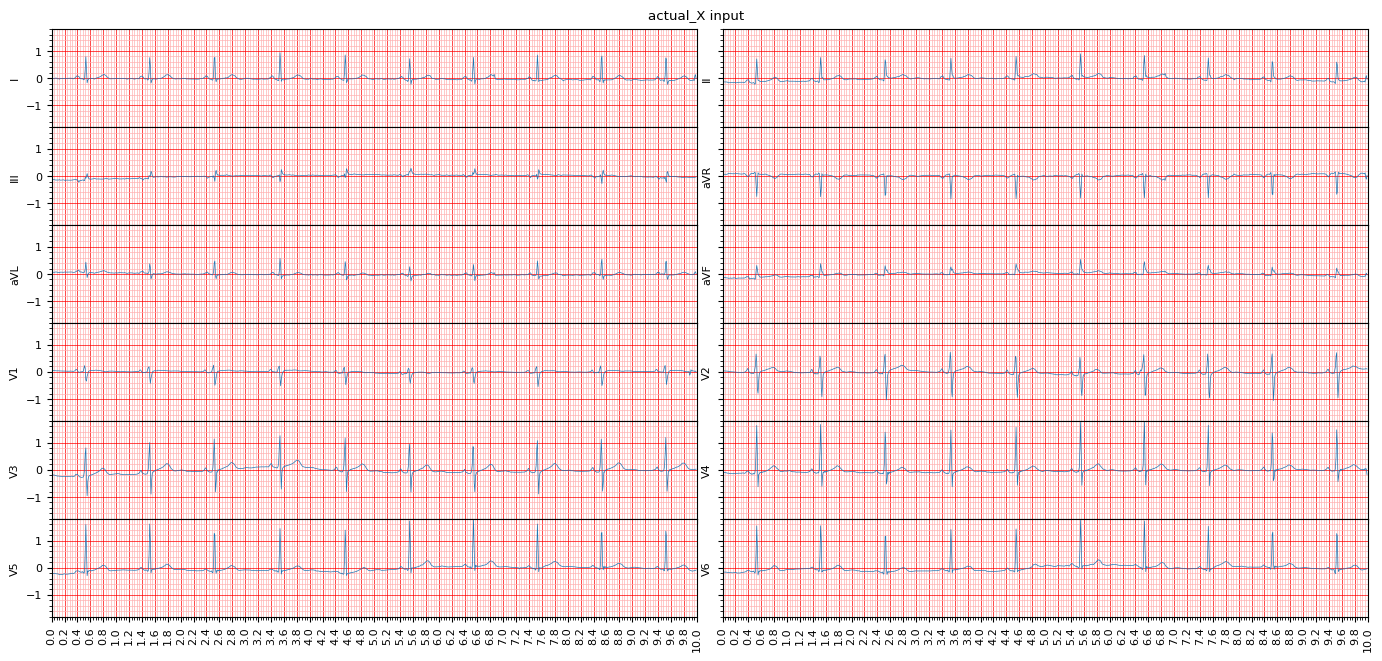

In [6]:
for i in range(5):
    ecg_plot.plot_12(tf.transpose(X_list[i], (0,2,1))[view_ind, :, :], sample_rate=sr, title = f"{X_list_names[i]} input")

In [7]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [8]:

with tf.device('/GPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X
    X_list_processed = []
    for i in range(5):
        X_list_processed.append(da_apply(X_list[i], func_dict))



In [9]:
def extract_features(model, layer_name, X):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    X_features = feature_extraction_model.predict(X)
    return X_features

def hybrid_prediction(cnn_model, xgb_model, X_new):
    # Extract features for new data using CNN-LSTM model
    X_new_features = extract_features(cnn_model, 'flatten', X_new)
    
    # Use XGBoost model to predict based on these features
    predictions = xgb_model.predict(X_new_features)
    
    return predictions

In [10]:
cnn_rnn_age_model = tf.keras.models.load_model('../../saved_models/100hz/age_models/cnn_rnn_age_model_8.03/')
cnn_rnn_sex_model = tf.keras.models.load_model('../../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5')
# # Make sure that the xgb model is the one associated with the cnn-lstm model
# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
# xgb_model.load_model('../../saved_models/retrainers/boost_retrainer/xgb_model_100_4.27_0.91.json')  # Make sure the file name matches the one used for saving


In [11]:
predicted_X_list_age = []
predicted_X_list_sex = []


with tf.device("/CPU:0"):
    def predict_age_set(model, X):
        predicted_age = model(tf.convert_to_tensor(X))
        return predicted_age
    
    def predict_sex_set(model, X):
        sex_temp = model(tf.convert_to_tensor(X))
        predicted_sex_prob = np.asarray(tf.squeeze(sex_temp))
        predicted_sex = np.where((np.squeeze(np.where(predicted_sex_prob >= 0.50, 1, 0))) == 1, 1, 0)
        return predicted_sex_prob, predicted_sex

for i in range(5):
    predicted_X_list_age.append(predict_age_set(cnn_rnn_age_model, X_list_processed[i]))
    predicted_X_list_sex.append(predict_sex_set(cnn_rnn_sex_model, X_list_processed[i])[1])


In [38]:
for i in range(5):
    print(type(predicted_X_list_sex[i]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


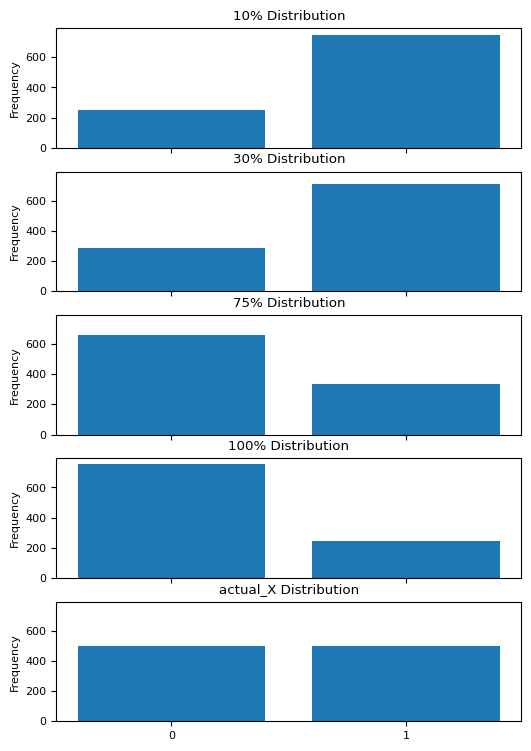

In [58]:

# Create histograms
fig, axs = plt.subplots(len(predicted_X_list_sex), 1, figsize=(6, 9), sharex=True, sharey = True)

bins = [-0.5, 0.5, 1.5]
labels = ['0', '1']

for i, arr in enumerate(predicted_X_list_sex):
    axs[i].hist(arr, bins=bins, rwidth=0.8)
    axs[i].set_title(f'{X_list_names[i]} Distribution')
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(labels)
    axs[i].set_ylabel('Frequency')

# Show the plot
plt.show()

## Metrics and Visuals

### Visuals

(array([251.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 749.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

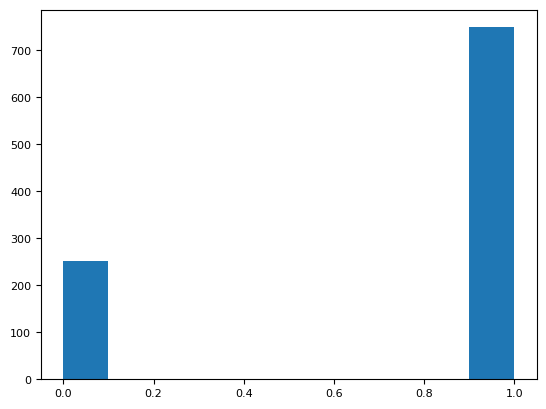

In [14]:
plt.hist(predicted_X_list_sex[0])